In [104]:
from spatialfacet import SpatialFacetMiner
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point

from sklearn.cluster import DBSCAN, OPTICS

In [256]:
## General Purpose Functions
def augment(facetminer, query, documents, n=50, retain_only_real = True):
    "a helper function for simpler query augmentation. Does remove all prefixed terms if wanted and zips results from C library  for a more pythonic user"
    #print(facetminer, query, documents, n)
    terms, weights, query = facetminer.augment(query,documents,n)
    the_filter = lambda x: True
    if retain_only_real:
        the_filter = lambda x: not x[0].isupper()
    return([(x,y) for x,y in zip(terms, weights) if the_filter(x)])

    
def query(se, query, first_result=1, last_result=10, min_visits=1000):
    se.query(query,first_result, last_result, min_visits)
    c0, c1, docs,wt = se.getSpyData();
    return c0,c1,docs, wt
        

def supervised_spatial_facet (se, query, U, first_result=1, last_result=10, min_visits=1000):
    se.query(query,first_result, last_result, min_visits)
    c0, c1, docs,wt = se.getSpyData();
    the_facet = get_facet(c0,c1,U) # ids of the facet
    print(the_facet)
    aug_keywords= augment(se, query, the_facet)
    return aug_keywords, the_facet



In [106]:
# Our example query regions
queries = {"U": Polygon([[-1,-1],[-1,1],[0,1],[0,-1],[-1,-1]]),
           "V": Polygon([[0,-1],[0,1],[1,1],[1,-1],[0,-1]]),
           "U-": Polygon([[-1,0.75],[-1,1],[0,1],[0,0.75],[-1,0.75]])
          }

# Spatial Facet Experiments
## Simple Experiment
A dataset generated in database/simple wiht two sides and queries for facets left, right, fair and small left showing the expected behavior


In [107]:
se = SpatialFacetMiner()
se.add_database("databases/simple","german")

'Opened a database with 10 entries.'

In [108]:
for Q in queries:
    print("%s: %s" %(Q, queries[Q]))
    kw, facet = supervised_spatial_facet(se,"red", queries[Q])
    print("Keywords Detected: %s" % (str(kw)))
    print("Underlying Facet IDs: %s" %(str(facet)))

U: POLYGON ((-1 -1, -1 1, 0 1, 0 -1, -1 -1))
[1, 2, 3, 4, 5]
Keywords Detected: [('green', 23.978952727983707)]
Underlying Facet IDs: [1, 2, 3, 4, 5]
V: POLYGON ((0 -1, 0 1, 1 1, 1 -1, 0 -1))
[6, 7, 8, 9, 10]
Keywords Detected: [('blue', 23.978952727983707)]
Underlying Facet IDs: [6, 7, 8, 9, 10]
U-: POLYGON ((-1 0.75, -1 1, 0 1, 0 0.75, -1 0.75))
[1, 4]
Keywords Detected: [('green', 4.122846072354315)]
Underlying Facet IDs: [1, 4]


## Simple Clustered (Experiment 2)

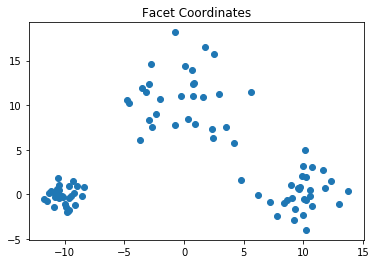

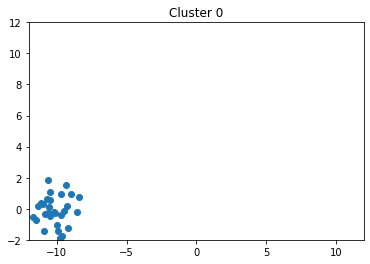

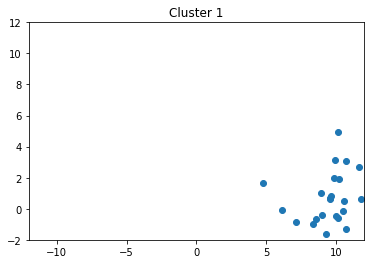

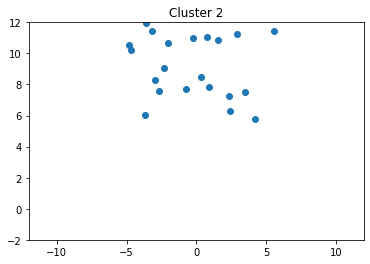

({0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 1: [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60], 2: [61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]}, {0: [('red', 267.19993229310154)], 1: [('green', 267.19993229310154)], 2: [('blue', 225.46675532419619)]}, {0: array([[ -9.50328585,  -0.1382643 ],
       [ -9.35231146,   1.52302986],
       [-10.23415337,  -0.23413696],
       [ -8.42078718,   0.76743473],
       [-10.46947439,   0.54256004],
       [-10.46341769,  -0.46572975],
       [ -9.75803773,  -1.91328024],
       [-11.72491783,  -0.56228753],
       [-11.01283112,   0.31424733],
       [-10.90802408,  -1.4123037 ],
       [ -8.53435123,  -0.2257763 ],
       [ -9.9324718 ,  -1.42474819],
       [-10.54438272,   0.11092259],
       [-11.15099358,   0.37569802],
      

In [272]:
# Dataset is now given as 3 clusters of normal distribution each having an identity and a joint keyword for the global search to 
# find all

def create_database_if_not_exists():
    import os 
    import xapian
    import json
    os.system("rm -Rf databases/simple_cluster")
    np.random.seed(42) 
    
    # black = everything
    # generate id, point, document tuples
    N=30
    database = []
    database = database + [("black red", x) for x in np.random.normal(size=2*N).reshape(-1,2) + [-10,0] ]
    database = database + [("black green", x) for x in np.random.normal(size=2*N).reshape(-1,2)*2 + [10,0] ]
    database = database + [("black blue", x) for x in np.random.normal(size=2*N).reshape(-1,2)*3 + [0,10] ]
    #plt.scatter([y[0] for x,y in database], [y[1] for x,y in database])
    #plt.show()
    
    db = xapian.WritableDatabase("databases/simple_cluster", xapian.DB_CREATE_OR_OPEN)
    termgenerator = xapian.TermGenerator()
    termgenerator.set_stemmer(xapian.Stem("en"))

    for i,x in enumerate(database):
        doc = xapian.Document()
        termgenerator.set_document(doc)
        obj = {"color": x[0],"location": [x[1][0],x[1][1]],"id":"%s_%05d"% (x[0].replace(" ","_"),i)}
        termgenerator.index_text(obj["color"], 1)
        doc.set_data(json.dumps(obj))
        doc.add_value(1, obj["color"])
        doc.add_value(2, json.dumps(obj["location"]))
        idterm = u"Q" + obj["id"]
        doc.add_boolean_term(idterm)
        db.replace_document(idterm, doc)
    return database

    
    
## Unsupervised example
create_database_if_not_exists()

se = SpatialFacetMiner()
se.add_database("databases/simple_cluster","de")
# black is here the "everything class"

hack = {}

def unsupervised_spatial_facet (se, query, first_result=1, last_result=10, min_visits=1000, debug=True):
    se.query(query,first_result, last_result, min_visits)
    c0, c1, docs,wt = se.getSpyData();
    coords = np.stack([c0,c1], axis=-1)
    if debug:
        plt.scatter(coords[:,0], coords[:,1])
        plt.title("Facet Coordinates")
        plt.savefig("facet-coordinates.png")
        plt.show()
        #15
    clustering = DBSCAN(eps=3, min_samples=3).fit(coords) # DBScan woudl work here as well
    hack["clustering"] = clustering.labels_
    hack["coords"] = coords
#    clustering = OPTICS (min_samples=3).fit(coords)
    if debug:
        for identity in range(np.max(clustering.labels_)+1):
            tmp = np.vstack([x for x,y in zip(coords, clustering.labels_) if y == identity ])
            plt.scatter(tmp[:,0], tmp[:,1])
            plt.xlim(-12,12)
            plt.ylim(-2,12)
            plt.title("Cluster %d" %(identity))
            plt.savefig("facet-cluster-%04d.png" % (identity))
            plt.show()
    facets = { x: [docs[y] for y in np.where(clustering.labels_ == x)[0]] for x in range(np.max(clustering.labels_)+1) }
    aug_keywords = {}
    for key in facets:
        aug_keywords [key] = augment(se, query, facets[key])
    facet_coords = {}
    for key in facets:
        facet_coords [key] = np.vstack([x for x,y in zip(coords, clustering.labels_) if y == key ])
    return  facets, aug_keywords, facet_coords 
    

facets = unsupervised_spatial_facet(se, "black")    
print(facets)


# Running this over Twitter



In [274]:

se = SpatialFacetMiner()
se.add_database("contrib/twitter/twitter-h5","en")



'Opened a database with 12920000 entries.'

In [ ]:
##c0,c1,docs, wt = query(se,'merkel',1,10,1000)
#plt.scatter(c0,c1, color=plt.get_cmap("viridis")(wt))
#plt.colorbar()
## good queries: apple, nato, "job hire",
## bushfire gives us exactly one cluster on us east cost
se = SpatialFacetMiner()
se.add_database("contrib/twitter/twitter-h5","en")
facets,keywords, coords = unsupervised_spatial_facet(se, "apple")
for id in facets:
    print("Facet %d starting: %s" %(id, str(facets[id][:20])))
    for i,k in enumerate(keywords[id]):
        print("%.2f\t%s" %(k[1],k[0]))
        if (i > 20):
            break
    plt.scatter(coords[id][:,0],coords[id][:,1])
    plt.show()


In [227]:
import matplotlib.pyplot as plt
import numpy as np
import math
import requests
from io import BytesIO
from PIL import Image
   
    
    
def deg2num(lat_deg, lon_deg, zoom):
  lat_rad = math.radians(lat_deg)
  n = 2.0 ** zoom
  xtile = int((lon_deg + 180.0) / 360.0 * n)
  ytile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
  return (xtile, ytile)
    
def num2deg(xtile, ytile, zoom):
  n = 2.0 ** zoom
  lon_deg = xtile / n * 360.0 - 180.0
  lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / n)))
  lat_deg = math.degrees(lat_rad)
  return (lat_deg, lon_deg)
import sys
def getImageCluster(lat_deg, lon_deg, delta_lat,  delta_long, zoom):
    headers = {"User-Agent":"My Own User-Agent"}
    smurl = r"http://a.tile.openstreetmap.org/{0}/{1}/{2}.png"
    xmin, ymax =deg2num(lat_deg, lon_deg, zoom)
    xmax, ymin =deg2num(lat_deg + delta_lat, lon_deg + delta_long, zoom)
   
    Cluster = Image.new('RGB',((xmax-xmin+1)*256-1,(ymax-ymin+1)*256-1) ) 
    for xtile in range(xmin, xmax+1):
        for ytile in range(ymin,  ymax+1):
            try:
                imgurl = smurl.format(zoom, xtile, ytile)
                print("Opening: " + imgurl)
                imgstr = requests.get(imgurl, headers=headers)
                tile = Image.open(BytesIO(imgstr.content))
                Cluster.paste(tile, box = ((xtile-xmin)*256 ,  (ytile-ymin)*255))
            except: 
                e = sys.exc_info()[0]
                print(imgstr.content)

                print("Couldn't download image %s " %(str(e)))
                tile = None
   
    return Cluster
    

Opening: http://a.tile.openstreetmap.org/13/2342/3144.png
Opening: http://a.tile.openstreetmap.org/13/2342/3145.png
Opening: http://a.tile.openstreetmap.org/13/2343/3144.png
Opening: http://a.tile.openstreetmap.org/13/2343/3145.png
Opening: http://a.tile.openstreetmap.org/13/2344/3144.png
Opening: http://a.tile.openstreetmap.org/13/2344/3145.png


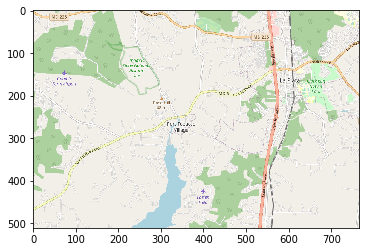

In [228]:
a = getImageCluster(38.5, -77.04, 0.02,  0.05, 13)
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.imshow(np.asarray(a))
plt.show()

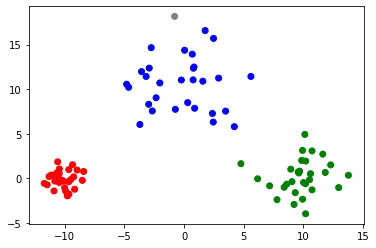

In [273]:
## visualize from hack

ctable={
    -1: "gray",
    0: "red",
    1: "green",
    2: "blue"
    
}
plt.scatter(hack["coords"][:,0],hack["coords"][:,1], color=[ctable[x] for x in hack["clustering"]])
plt.savefig("clustering-result.png")